# AUC and performande using Selected Peptides

In [1]:
from matplotlib import pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from os.path import join, dirname, abspath
import shap
import tqdm

In [2]:
important_peptides = pd.read_csv(join('..', 'Results', 'Top100_SHAP_peptides_only.csv'))

In [3]:
important_peptides

,peptide_name,0
0,twist_54214,0.574447
1,twist_43798,0.306844
2,agilent_9025,0.208874
3,agilent_241665,0.203662
4,twist_51296,0.198013
...,...,...
95,agilent_169922,0.000772
96,corona2_425,0.000000
97,corona2_3290,0.000000
98,corona2_4309,0.000000


In [4]:
metadata = pd.read_csv(join('..', 'Data', 'metadata.csv')).dropna()
metadata['sample_id'] = metadata['sample_id'].apply(lambda x: str(x).replace('.', '-'))
metadata
metadata.set_index('sample_id', inplace = True)
exist_data = pd.read_csv(join('..', 'Data', 'exist.csv'))
exist_data = exist_data.T 
exist_data.columns = exist_data.iloc[0]
exist_data = exist_data[1:]

X = exist_data.copy().astype('category')

y = metadata['type_person']
y = y.apply(lambda x: 0 if x == 'Control' else 1).astype('category')

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut, KFold
from sklearn.model_selection import StratifiedKFold
n_features = len(important_peptides)
dict_cross_val = {
    'mean_accuracy': [],
    'std_accuracy': [],
    'mean_roc_auc': [],
    'std_roc_auc': [],
}
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'seed': 100,
    'alpha': 0.2
}


for i in tqdm.tqdm(range(n_features)):
    names = important_peptides[:i+1]['peptide_name'].to_list()
    X_subset = X[names]
    cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)
    bst = XGBClassifier(**params, n_estimators=100, enable_categorical=True)
    scores = cross_val_score(bst, X_subset, y, cv=cv, scoring='accuracy', n_jobs=-1)
    dict_cross_val['mean_accuracy'].append(scores.mean())
    dict_cross_val['std_accuracy'].append(scores.std())
    scores_2 = cross_val_score(bst, X_subset, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    dict_cross_val['mean_roc_auc'].append(scores_2.mean())
    dict_cross_val['std_roc_auc'].append(scores_2.std())

100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


Text(0, 0.5, 'Mean RUC AUC')

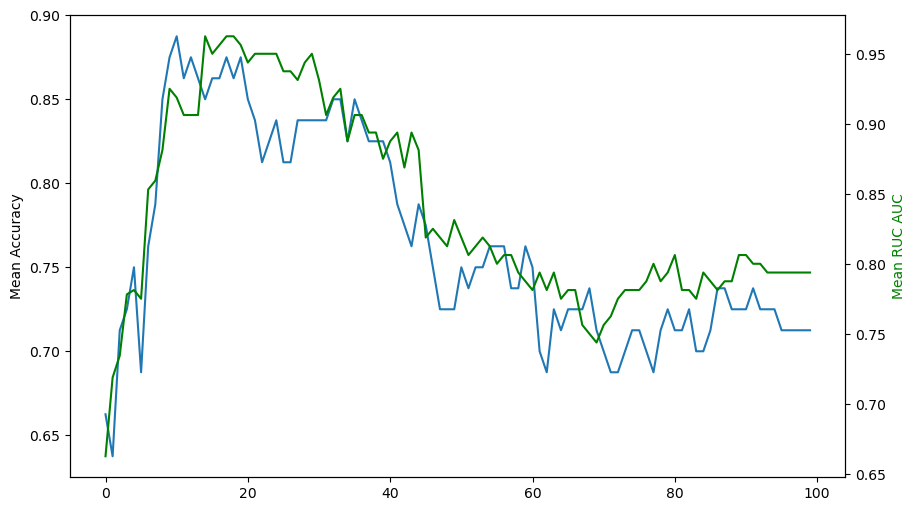

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dict_cross_val['mean_accuracy'])
ax.set_ylabel('Mean Accuracy')
axt = ax.twinx()
axt.plot(dict_cross_val['mean_roc_auc'], color = 'green')
axt.set_ylabel('Mean RUC AUC', color = 'green')

In [7]:
dict_cross_val['n_features'] = list(range(1, n_features + 1))
cross_val_df = pd.DataFrame(dict_cross_val)
# features = median_importance.index[:50].to_list()
cross_val_df.sort_values(by='mean_roc_auc', ascending=False, inplace=True)
n_features_optimal = cross_val_df.iloc[0]['n_features'].astype(int)
opt_features = important_peptides[:n_features_optimal]['peptide_name'].to_list()
print(f'Optimal number of features: {n_features_optimal}')
print(f'Optimal features: {opt_features}')

Optimal number of features: 18
Optimal features: ['twist_54214', 'twist_43798', 'agilent_9025', 'agilent_241665', 'twist_51296', 'agilent_8318', 'corona2_8999', 'twist_54947', 'twist_46426', 'agilent_240812', 'agilent_6936', 'agilent_242591', 'twist_48320', 'agilent_12023', 'twist_55260', 'twist_56007', 'twist_58788', 'twist_25251']


/opt/homebrew/Caskroom/miniconda/base/envs/SaaLab/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/SaaLab/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/SaaLab/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/SaaLab/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/SaaLab/lib/python3.9/site-packages/sklearn/metrics/_r

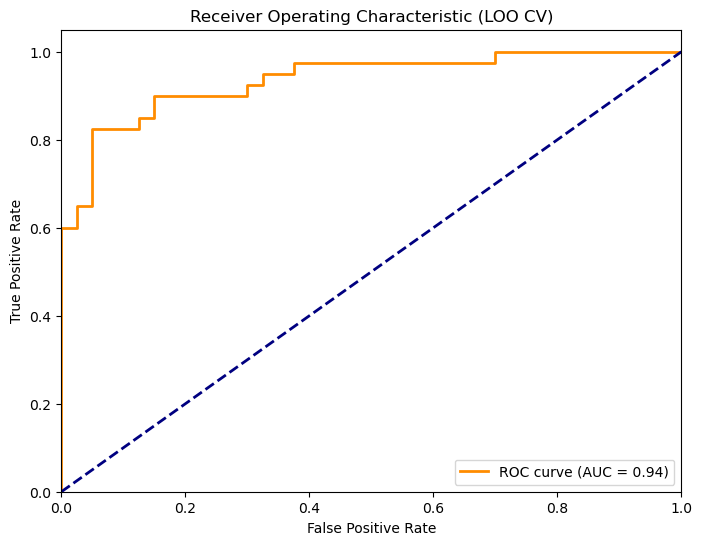

In [40]:
from sklearn.model_selection import LeaveOneOut, StratifiedKFold
from sklearn.metrics import roc_curve, auc
# LOO CV with optimal features

X_opt = X[opt_features]
y = y.copy()

cv = LeaveOneOut()
y_true = []
y_pred_proba = []
# make a loo cv
for train_index, test_index in cv.split(X_opt, y):
    X_train, X_test = X_opt.iloc[train_index], X_opt.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # print(test_index)
    model = XGBClassifier(**params, n_estimators=200, enable_categorical=True)
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    y_true.extend(y_test)
    y_pred_proba.extend(y_prob)

# # Calculate ROC curve and AUC

fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (LOO CV)')
plt.legend(loc='lower right')
plt.show()


# SHAP

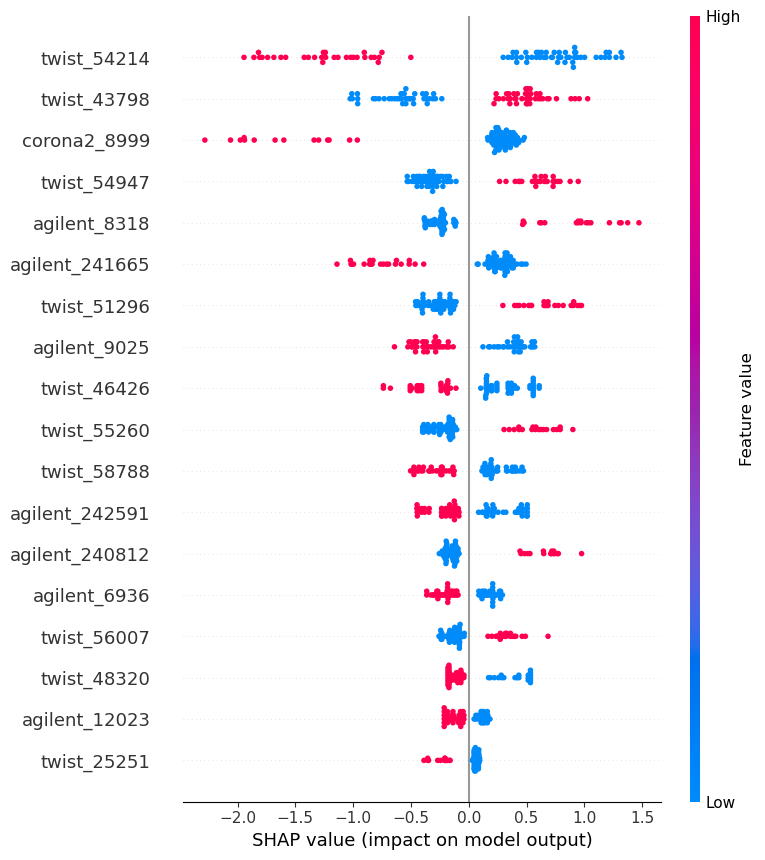

In [42]:
# shap training
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold

X_subset = X[opt_features]


bst = XGBClassifier(
    **params, n_estimators=100, enable_categorical=True
)
bst.fit(X_subset, y)
    
shap_values = shap.TreeExplainer(bst).shap_values(X_subset)

shap.summary_plot(shap_values, X_subset.astype('float64'))

# Table

In [ ]:
peptide_info = pd.read_csv(join('..','Data', 'peptide_libraries_info.csv'))

In [86]:
shap_values_pd = pd.DataFrame(shap_values, columns=X_subset.columns)
abs_shap_values = shap_values_pd.abs().mean(axis = 0)
subset_metadata = X_subset.copy()
subset_metadata['type_person'] = y.values

control = subset_metadata[subset_metadata['type_person'] == 0].drop(columns=['type_person']).astype(int)
ibd = subset_metadata[subset_metadata['type_person'] == 1].drop(columns=['type_person']).astype(int)    

# ods_control
ods_control = control.mean(axis = 0)
ods_ibd = ibd.mean(axis = 0)

# ods_ratio
ods_ratio = np.log(ods_ibd / ods_control)


# peptides_important
peptides_important = peptide_info.set_index('peptide_name').loc[opt_features]

position = peptides_important['pos']
len_seq = peptides_important['len_seq']
description_pep = peptides_important['Description']
specie = peptides_important['species']

table = pd.DataFrame({
    'Position': position,
    'Length': len_seq,
    'Description': description_pep,
    'Species': specie,
    'mean_abs_shap': abs_shap_values,
    '%Control': ods_control,
    '%IBD': ods_ibd,
    'log(ods_ratio)': ods_ratio
})  

In [88]:
table.to_csv(join('..', 'Results', 'SHAP_selected_peptides_table_results.csv'))

In [76]:
peptide_info

,peptide_name,aa_seq,pos,len_seq,full name,Description,is_IEDB_or_cntrl,is_auto,is_infect,is_EBV,...,is_allergens,domain,kingdom,phylum,class,order,family,genus,species,common
0,agilent_10,AAAQKETLNQPGEQGNAITSHQMQSGKQLDDMHKENGKSGTVTEGK...,44,690.0,Lipase 2 precursor (Glycerol ester hydrolase 2),Lipase 2,True,False,True,False,...,NaN,Bacteria,Bacillati,Bacillota,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,Staphylococcus aureus,NaN
1,agilent_100076,KIKGNAYYNLKTETGKLGGSAEPGIVFVSKDVNGNGEPDDEWYELA...,440,637.0,MH0280_GL0054533 MPA_PNP_EM_seqs_non_topgraph_...,Uncharacterized protein,False,False,False,False,...,NaN,Bacteria,Pseudomonadati,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides caccae,NaN
2,agilent_100147,KILKPLKWEVALDLGGVTQGYCGGKTAGSDNWKVVTLKTDGTLHRK...,748,907.0,MH0319_GL0092936 MPA_PNP_EM_seqs_non_topgraph_...,Beta-galactosidase,False,False,False,False,...,NaN,Bacteria,Pseudomonadati,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides caccae,NaN
3,agilent_100176,KIMDTKSYSLSTTKESGLPAYQSLFCSTDLTQNPEMILVADYDKAL...,220,579.0,YP_101056.1 strains_non_MPA_non_topgraph_cdhit...,Uncharacterized protein,False,False,False,False,...,NaN,Bacteria,Pseudomonadati,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides fragilis,NaN
4,agilent_100204,KINFVRNQKKVSFNGRIPSNVQKQLNSEKIQIVINPKLKHNGTFSL...,88,240.0,O2.UC50-2_GL0004449 MPA_PNP_EM_seqs_non_topgra...,Uncharacterized protein,False,False,False,False,...,NaN,Bacteria,Bacillati,Bacillota,Clostridia,Lachnospirales,Lachnospiraceae,Anaerostipes,Anaerostipes hadrus,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13101,twist_99816,DLSVIMRGMQEQLDTFAVPNKWIVVRTNAEEAPLRSVYTNDNPASP...,238,381.0,NaN,hypothetical protein PBC1_019,NaN,False,False,False,...,False,NaN,Heunggongvirae,Uroviricota,Caudoviricetes,NaN,NaN,Pebcunavirus,Pebcunavirus PBC1,NaN
13102,twist_99830,EEANERLLNIVLDEDPTEAFNKIGQEAFLIKSKIDSYNKVIKMYHD...,238,562.0,NaN,endonuclease subunit,NaN,False,False,False,...,False,NaN,Heunggongvirae,Uroviricota,Caudoviricetes,NaN,Straboviridae,Mosigvirus,Mosigvirus JS09,NaN
13103,twist_99880,GKVRNFKKQTIKLNKIGREFVGVKVEQSIITADQDSSLLDQTAGVP...,68,1134.0,NaN,hypothetical protein,NaN,False,False,False,...,False,NaN,Heunggongvirae,Uroviricota,Caudoviricetes,NaN,Herelleviridae,Pecentumvirus,Pecentumvirus list36,NaN
13104,twist_99911,IKDFKKITNSDFQRYQAGVEKGKNGKIIVHSMENNGAEMVVWKAYG...,68,131.0,NaN,hypothetical protein,NaN,False,False,False,...,False,NaN,Heunggongvirae,Uroviricota,Caudoviricetes,NaN,Straboviridae,Gelderlandvirus,Gelderlandvirus s16,NaN
